<a href="https://colab.research.google.com/github/baalasangar/MLAI/blob/master/13_Capstone/Model_building_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Objective:
 - Train  a neural network model which can predict is the patience is affected or not.
 - sample images are taken from the population ( considering the distripution of the data like *****)
 - sample  Train Image - 500 postive images 500 negative images
 - sample Test Image - 50 postive and 50 negative images
 - xray images of 512 * 512 are the input to the model
 - evaluation metrics - recall
 - conclution is performed with comparing different models ( classification metrix, loss vs accuracy & classification report ) 






### Load lib and data

In [3]:
!pip install pydicom

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


from sklearn.utils import class_weight
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import recall_score,precision_score,roc_auc_score,accuracy_score,confusion_matrix,roc_curve,plot_roc_curve


import cv2
import pydicom as dicom
from pydicom.pixel_data_handlers.util import apply_voi_lut

import pickle

import logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s :: %(levelname)s :: %(message)s')



import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout,Activation,BatchNormalization,Flatten,Conv2D,MaxPooling2D,MaxPool2D,GlobalMaxPooling2D,Input
from tensorflow.keras.optimizers import SGD,RMSprop,Adam
from tensorflow.keras.constraints import max_norm
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau
from tensorflow.keras.regularizers import l2


In [6]:
RANDOM_SEED = 123
np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

In [7]:
META_DATA = "/content/drive/MyDrive/GreatLearning/Captone_project/Code/Baala/final_data.csv"
DATA_ROOT_PATH = "/content/drive/MyDrive/GreatLearning/Captone_project/Pneumonia _DS/"


META_DATA,DATA_ROOT_PATH

('/content/drive/MyDrive/GreatLearning/Captone_project/Code/Baala/final_data.csv',
 '/content/drive/MyDrive/GreatLearning/Captone_project/Pneumonia _DS/')

In [8]:
metadata_df = pd.read_csv(META_DATA)
metadata_df.drop(labels= ["Unnamed: 0"], axis=1,inplace=True)
metadata_df.head()

,patientId,x,y,width,height,Target,class,filepath,Train_or_Test,area,age,sex,ViewPosition,BodyPartExamined
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal,/content/drive/MyDrive/GreatLearning/Captone_p...,Train,NaN,51,F,PA,CHEST
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal,/content/drive/MyDrive/GreatLearning/Captone_p...,Train,NaN,48,F,PA,CHEST
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal,/content/drive/MyDrive/GreatLearning/Captone_p...,Train,NaN,19,M,AP,CHEST
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0,Normal,/content/drive/MyDrive/GreatLearning/Captone_p...,Train,NaN,28,M,PA,CHEST
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1,Lung Opacity,/content/drive/MyDrive/GreatLearning/Captone_p...,Train,80727.0,32,F,AP,CHEST


### sample data for model building
 - from EDA , ViewPosition  ( PA and AP  ) influence the orientation of the xray . So the sampling is done by considering  ViewPosition

2021-08-16 00:17:40,194 :: INFO :: NumExpr defaulting to 4 threads.


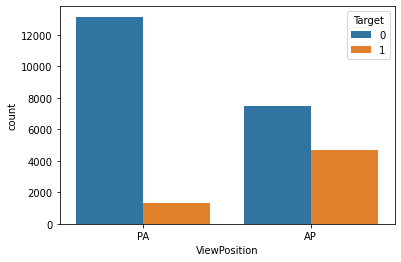

In [9]:
sns.countplot(data = metadata_df[["patientId","Target","ViewPosition"]].drop_duplicates(),x="ViewPosition",hue="Target")
plt.show()

In [10]:
SAMPLE_SIZE = 5000
sampled_metadata = pd.DataFrame(columns=["patientId","Target","ViewPosition","filepath"])

In [11]:
pa_count = metadata_df.query("ViewPosition == 'PA' & Target == 1")[["patientId","Target","ViewPosition"]].drop_duplicates().shape[0]
ap_count = metadata_df.query("ViewPosition == 'AP' & Target == 1")[["patientId","Target","ViewPosition"]].drop_duplicates().shape[0]

pa_count_sample_size = int(round(pa_count / (pa_count+ap_count),2) * SAMPLE_SIZE)
ap_count_sample_size = int(round(ap_count / (pa_count+ap_count),2) * SAMPLE_SIZE)

print(pa_count_sample_size,ap_count_sample_size)

sampled_metadata = sampled_metadata.append(metadata_df.query("ViewPosition == 'PA' & Target == 1")[["patientId","Target","ViewPosition","filepath"]].drop_duplicates().sample(n=pa_count_sample_size,random_state=RANDOM_SEED))
sampled_metadata = sampled_metadata.append(metadata_df.query("ViewPosition == 'AP' & Target == 1")[["patientId","Target","ViewPosition","filepath"]].drop_duplicates().sample(n=ap_count_sample_size,random_state=RANDOM_SEED))


1100 3900


In [12]:
pa_count = metadata_df.query("ViewPosition == 'PA' & Target == 0")[["patientId","Target","ViewPosition"]].drop_duplicates().shape[0]
ap_count = metadata_df.query("ViewPosition == 'AP' & Target == 0")[["patientId","Target","ViewPosition"]].drop_duplicates().shape[0]

pa_count_sample_size = int(round(pa_count / (pa_count+ap_count),2) * SAMPLE_SIZE)
ap_count_sample_size = int(round(ap_count / (pa_count+ap_count),2) * SAMPLE_SIZE)

print(pa_count_sample_size,ap_count_sample_size)

sampled_metadata = sampled_metadata.append(metadata_df.query("ViewPosition == 'PA' & Target == 0")[["patientId","Target","ViewPosition","filepath"]].drop_duplicates().sample(n=pa_count_sample_size,random_state=RANDOM_SEED))
sampled_metadata = sampled_metadata.append(metadata_df.query("ViewPosition == 'AP' & Target == 0")[["patientId","Target","ViewPosition","filepath"]].drop_duplicates().sample(n=ap_count_sample_size,random_state=RANDOM_SEED))


3200 1800


In [13]:
sampled_metadata.reset_index(drop=True,inplace=True )
print(sampled_metadata.shape)
sampled_metadata.head()

(10000, 4)


,patientId,Target,ViewPosition,filepath
0,e18c7203-a029-4cf4-8151-2bc2460c390c,1,PA,/content/drive/MyDrive/GreatLearning/Captone_p...
1,18ce990f-bea9-4174-a6a2-8f61c4517b24,1,PA,/content/drive/MyDrive/GreatLearning/Captone_p...
2,068b608d-f71c-4859-b909-62c1665b507f,1,PA,/content/drive/MyDrive/GreatLearning/Captone_p...
3,9fa17c26-8aae-4dd6-af8a-5750f042adf9,1,PA,/content/drive/MyDrive/GreatLearning/Captone_p...
4,722503cf-a801-415b-a10e-848bfea55911,1,PA,/content/drive/MyDrive/GreatLearning/Captone_p...


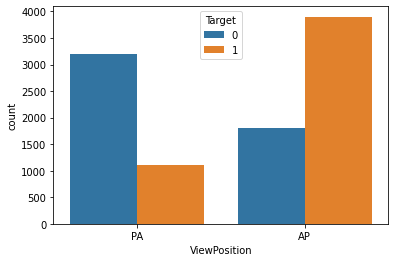

In [14]:
# distibution of the sample dataset similar to the population 

sns.countplot(data = sampled_metadata,x="ViewPosition",hue="Target")

### reading , postprocessing, reshaping Img

In [15]:
### reading the image and storing it as pickle for later access

# def read_img(index_list):
#   image_list = []
#   label_list = []
#   for index in index_list:
#     filePath = sampled_metadata.loc[index]["filepath"]
#     image_list.append(dicom.dcmread(filePath).pixel_array)
#     label_list.append(sampled_metadata.loc[index]["Target"])
#   return image_list,label_list

# index_list = list(sampled_metadata.index)
# X,y = read_img(index_list)
# X = np.array(X)
# y = np.array(y)

# with open('/content/drive/MyDrive/GreatLearning/Captone_project/Code/Baala/image_list.pkl','wb') as f:
#   pickle.dump(X, f,pickle.HIGHEST_PROTOCOL)

# with open('/content/drive/MyDrive/GreatLearning/Captone_project/Code/Baala/label_list.pkl','wb') as f:
#   pickle.dump(y, f,pickle.HIGHEST_PROTOCOL)  

#### reading img

In [16]:
with open('/content/drive/MyDrive/GreatLearning/Captone_project/Code/Baala/image_list.pkl','rb') as f:
  X_image_list = pickle.load(f)

with open('/content/drive/MyDrive/GreatLearning/Captone_project/Code/Baala/label_list.pkl','rb') as f:
  y_lable_value = pickle.load(f)

In [17]:
X_image_list.shape

(10000, 1024, 1024)

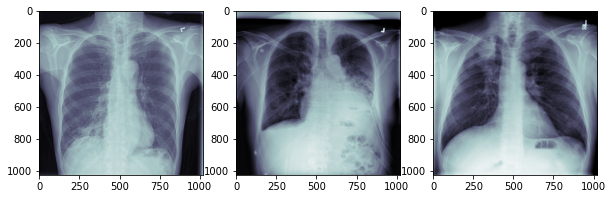

In [18]:
plt.figure(figsize=(10, 10))
for i in range(0,3):
  ax = plt.subplot(1, 3, i + 1)
  plt.imshow(X_image_list[i],"bone") 
plt.show()

#### CLAHE processing - improve the contrast of images
 - Contrast Limited Adaptive Histogram Equalization (CLAHE) to equalize images. CLAHE is a variant of Adaptive histogram equalization (AHE) which takes care of over-amplification of the contrast
 

In [19]:
# def CLAHEprocessing(img):
#   clahe = cv2.createCLAHE(clipLimit = 5)
#   clahe_img = clahe.apply(img) + 30
#   return clahe_img

# X_image_list = [CLAHEprocessing(img) for img in X_image_list]

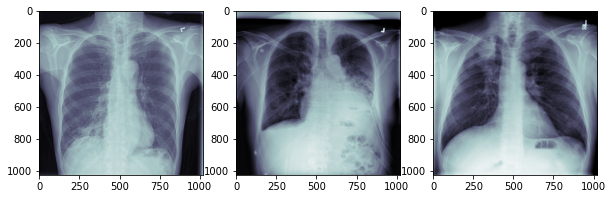

In [20]:
plt.figure(figsize=(10, 10))
for i in range(0,3):
  ax = plt.subplot(1, 3, i + 1)
  plt.imshow(X_image_list[i],"bone") 
plt.show()

#### reshaping image

In [21]:
IMG_HEIGHT_WIDTH = 128
# resizing the image 512 * 512
X_image_reshaped = [cv2.resize(img,(IMG_HEIGHT_WIDTH,IMG_HEIGHT_WIDTH)) for img in X_image_list]
print("Shape of the image after resizing", X_image_reshaped[0].shape)

Shape of the image after resizing (128, 128)


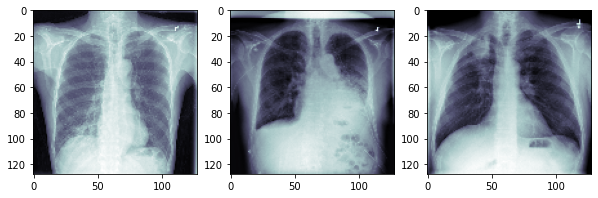

In [22]:
plt.figure(figsize=(10, 10))
for i in range(0,3):
  ax = plt.subplot(1, 3, i + 1)
  plt.imshow(X_image_reshaped[i],"bone") 
plt.show()

In [23]:
# index = list(sampled_metadata.query("patientId == 'e18c7203-a029-4cf4-8151-2bc2460c390c'").index)
# testpath = sampled_metadata.loc[index[0]]["filepath"]
# img = dicom.dcmread(testpath).pixel_array
# # logging.info(testpath, testpath.dtype)
# # img = dicom.dcmread(testpath).pixel_array
# print(img.shape,img.min(),img.max())
# plt.imshow(img,"bone") 
# plt.show()

# img = cv2.resize(img,(512,512),interpolation = cv2.INTER_AREA)
# plt.imshow(img,"bone") 
# plt.show()
# print(img.shape,img.min(),img.max())


# clahe = cv2.createCLAHE(clipLimit = 5)
# clahe_img = clahe.apply(img) + 30
# plt.imshow(clahe_img,"bone") 
# plt.show()


### Train & test data split

In [24]:
X_train, X_test_validate, y_train, y_test_validate = train_test_split(np.array(X_image_reshaped), y_lable_value, test_size=0.3, random_state=RANDOM_SEED,stratify=y_lable_value)

X_test, X_validate, y_test, y_validate = train_test_split(X_test_validate, y_test_validate, test_size=0.2, random_state=RANDOM_SEED,stratify=y_test_validate)



In [25]:
print("X_train data shape ", X_train.shape)
print("y_train data shape ", y_train.shape)

print("X_test data shape ", X_test.shape)
print("y_test data shape ", y_test.shape)

print("X_validate data shape ", X_validate.shape)
print("y_validate data shape ", y_validate.shape)


X_train data shape  (7000, 128, 128)
y_train data shape  (7000,)
X_test data shape  (2400, 128, 128)
y_test data shape  (2400,)
X_validate data shape  (600, 128, 128)
y_validate data shape  (600,)


In [26]:
print("distribution in Train \n", np.array(np.unique(y_train, return_counts=True)).T)
print("distribution in Test \n", np.array(np.unique(y_test, return_counts=True)).T)
print("distribution in Validate \n", np.array(np.unique(y_validate, return_counts=True)).T)

distribution in Train 
 [[   0 3500]
 [   1 3500]]
distribution in Test 
 [[   0 1200]
 [   1 1200]]
distribution in Validate 
 [[  0 300]
 [  1 300]]


### Normalize the image

In [27]:
normalizeimg = lambda x: (np.array(x) / 255.0).astype('float32')

## Normalize 
X_train = normalizeimg(X_train)
X_test = normalizeimg(X_test)
X_validate = normalizeimg(X_validate)

print("X_train min / max ", X_train.min(),X_train.max())
print("X_test min / max ", X_test.min(),X_test.max())
print("X_test min / max ", X_validate.min(),X_validate.max())

X_train min / max  0.0 1.0
X_test min / max  0.0 1.0
X_test min / max  0.0 1.0


### Reshape image to ( h*w) -> (h *w *c)

In [28]:
f_resize = lambda x: np.array(x).reshape(-1, IMG_HEIGHT_WIDTH, IMG_HEIGHT_WIDTH, 1)

X_train = f_resize(X_train)
X_test = f_resize(X_test)
X_validate = f_resize(X_validate)

print("X_train data shape ", X_train.shape)
print("y_train data shape ", y_train.shape)

print("X_test data shape ", X_test.shape)
print("y_test data shape ", y_test.shape)

print("X_validate data shape ", X_validate.shape)
print("y_validate data shape ", y_validate.shape)


X_train data shape  (7000, 128, 128, 1)
y_train data shape  (7000,)
X_test data shape  (2400, 128, 128, 1)
y_test data shape  (2400,)
X_validate data shape  (600, 128, 128, 1)
y_validate data shape  (600,)


### Model Building
 - Inscepton Model ( transfer learning ) 
 - Resnet ( transfer learning ) 
 - Model from scratch
 

In [29]:
metrics_data = pd.DataFrame(columns=["model","train_score","test_score","validate_score","auc","recall","precision","cm"])

# def get_metrics(model_name):
#   metric = {
#     "model":model_name,
#     "train_score":round(accuracy_score(y_train,y_train_predict),2),
#     "test_score":round(accuracy_score(y_test,y_predict),2),
#     "auc":round(roc_auc_score(y_test,y_predict),2),
#     "recall":round(recall_score(y_test,y_predict),2),
#     "precision":round(precision_score(y_test,y_predict),2),
#     "cm":confusion_matrix(y_test,y_predict)
#     }
#   return metric


def plot_roccurve(y_true, y_score):
    """plot_roc_curve."""
    false_positive_rate, true_positive_rate, thresholds = roc_curve(
        y_true, y_score)
    plt.plot(false_positive_rate, true_positive_rate, lw=2, color='navy')
    plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.ylim([-0.05, 1.05])
    plt.xlim([-0.05, 1.05])
    plt.grid()
    plt.title('Receiver operating characteristic AUC={0:0.2f}'.format(
        roc_auc_score(y_true, y_score))) 
    return plt


#### SVC + PCA

In [27]:
# ### Reshape input for  SVC 
# X_train_svc = X_train.reshape(X_train.shape[0],IMG_HEIGHT_WIDTH*IMG_HEIGHT_WIDTH)
# print("X_train_svc data shape ", X_train_svc.shape)

# X_test_svc= X_test.reshape(X_test.shape[0],IMG_HEIGHT_WIDTH*IMG_HEIGHT_WIDTH)
# print("X_test_svc data shape ", X_test_svc.shape)

# X_validate_svc= X_validate.reshape(X_validate.shape[0],IMG_HEIGHT_WIDTH*IMG_HEIGHT_WIDTH)
# print("X_validate_svc data shape ", X_validate_svc.shape)

# print("y_train data shape ", y_train.shape)
# print("y_test data shape ", y_test.shape)
# print("y_test data shape ", y_validate.shape)


# pca = PCA(0.95)
# estimator = SVC(kernel="rbf")
# param_grid = {    
#     "estimator__C":[1],
#     "estimator__gamma":[0.001],

# }
# pipe = Pipeline(steps=[('pca', pca), ('estimator', estimator)])
# gridsearch = GridSearchCV(pipe, param_grid, n_jobs=-1,scoring = "recall")
# gridsearch.fit(X_train_svc,y_train)


# with open('/content/drive/MyDrive/GreatLearning/Captone_project/Code/Baala/svc_model.pkl','wb') as f:
#   pickle.dump(best_estimator_, f,pickle.HIGHEST_PROTOCOL)


In [28]:
# with open('/content/drive/MyDrive/GreatLearning/Captone_project/Code/Baala/svc_model.pkl','rb') as f:
#   svc_model = pickle.load(f)

# y_predict = svc_model.predict(X_test_svc)
# y_train_predict = svc_model.predict(X_train_svc)
# y_validate_predict = svc_model.predict(X_validate_svc)

In [29]:
# model_name = "SVC+PCA"
 
# metric = {
#     "model":model_name,
#     "train_score":round(accuracy_score(y_train,y_train_predict),2),
#     "test_score":round(accuracy_score(y_test,y_predict),2),
#     "validate_score":round(accuracy_score(y_validate,y_validate_predict),2)
#     "auc":round(roc_auc_score(y_validate,y_validate_predict),2),
#     "recall":round(recall_score(y_validate,y_validate_predict),2),
#     "precision":round(precision_score(y_validate,y_validate_predict),2),
#     "cm":confusion_matrix(y_validate,y_validate_predict)
#     }
# metrics_data = metrics_data.append(metric,ignore_index = True)
# metrics_data[metrics_data["model"] == model_name]


# print("Best param ", gridsearch.best_params_)
# print(" \n")

# fig,ax = plt.subplots(nrows=1,ncols=2,figsize=(15, 5))
# sns.heatmap(confusion_matrix(y_test,y_predict),annot=True,ax=ax[0],cmap="YlGnBu")
# ax[0].set_title('Confusion Matrix'); 
# ax[1] = plot_roccurve(y_test,y_predict)
# plt.show() 


#### Neural Network

In [30]:
# def nn_model_dropout(kernel_initializer = "normal"):
#     model = Sequential()
#     model.add(Flatten())

#     model.add(Dense(512, activation = "relu"))   
#     model.add(BatchNormalization())

#     model.add(Dense(256, activation = "relu"))   
#     model.add(BatchNormalization())
    
#     model.add(Dense(128, activation = "relu"))   
#     model.add(BatchNormalization())
#     model.add(Dropout(0.2))

#     model.add(Dense(64, activation = "relu"))   
#     model.add(BatchNormalization())

#     model.add(Dense(32, activation = "relu"))   
#     model.add(BatchNormalization())
    
#     model.add(Dense(1, activation = "sigmoid"))
#     return model


# def nn_model():
#   inputs = Input(shape=(IMG_HEIGHT_WIDTH, IMG_HEIGHT_WIDTH))
#   x = Flatten()(inputs)
#   x = Dense(units=512, activation='relu')(x)
#   x = Dropout(rate=0.7)(x)
#   x = Dense(units=128, activation='relu')(x)  
#   #x = Dropout(rate=0.5)(x)
#   x = Dense(units=64, activation='relu')(x)
#   x = Dense(units=32, activation='relu')(x)
#   x = Dense(units=16, activation='relu')(x)
#   x = Dropout(rate=0.1)(x)

#   output = Dense(units=1, activation='sigmoid')(x)
#   model = Model(inputs=inputs, outputs=output)
#   return model

def nn_model():
  model = Sequential()
  model.add(Flatten())
  model.add(Dense(216,  activation = "relu"))   
  #model.add(BatchNormalization())
  #model.add(Dropout(0.2))
  
  model.add(Dense(128,  activation = "relu"))   
  #model.add(BatchNormalization())
  model.add(Dropout(0.2))

  model.add(Dense(64,  activation = "relu"))   
  #model.add(BatchNormalization())
  #model.add(Dropout(0.2))
  
  model.add(Dense(1, activation = "sigmoid"))
  return model



nn_model = nn_model()
optimizer = SGD(learning_rate=0.001,momentum=0.9  )

es = EarlyStopping(monitor='val_loss', patience=10,min_delta=0.0001)

nn_model.compile(optimizer = optimizer, loss= tf.keras.losses.BinaryCrossentropy(), 
                   metrics = ["accuracy",
                              tf.keras.metrics.Precision(name="precision"),
                              tf.keras.metrics.Recall(name="recall")])

learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', 
                                            patience=2, 
                                            verbose=1, 
                                            factor=0.01, 
                                            min_lr=0.001)

fit_data = nn_model.fit(X_train, y_train, validation_data=(X_test,y_test),
                           batch_size = 32, epochs = 100, verbose = 1,callbacks=[es,learning_rate_reduction])

Epoch 1/100
219/219 [==============================] - 3s 6ms/step - loss: 0.6241 - accuracy: 0.6496 - precision: 0.6462 - recall: 0.6611 - val_loss: 0.5817 - val_accuracy: 0.7121 - val_precision: 0.7242 - val_recall: 0.6850
Epoch 2/100
219/219 [==============================] - 1s 4ms/step - loss: 0.5848 - accuracy: 0.7016 - precision: 0.6940 - recall: 0.7211 - val_loss: 0.5852 - val_accuracy: 0.7058 - val_precision: 0.7475 - val_recall: 0.6217
Epoch 3/100
219/219 [==============================] - 1s 4ms/step - loss: 0.5724 - accuracy: 0.7083 - precision: 0.7003 - recall: 0.7283 - val_loss: 0.5918 - val_accuracy: 0.6954 - val_precision: 0.7585 - val_recall: 0.5733
Epoch 4/100
219/219 [==============================] - 1s 4ms/step - loss: 0.5647 - accuracy: 0.7140 - precision: 0.7009 - recall: 0.7466 - val_loss: 0.5803 - val_accuracy: 0.7196 - val_precision: 0.7363 - val_recall: 0.6842
Epoch 5/100
219/219 [==============================] - 1s 4ms/step - loss: 0.5581 - accuracy: 0.7254

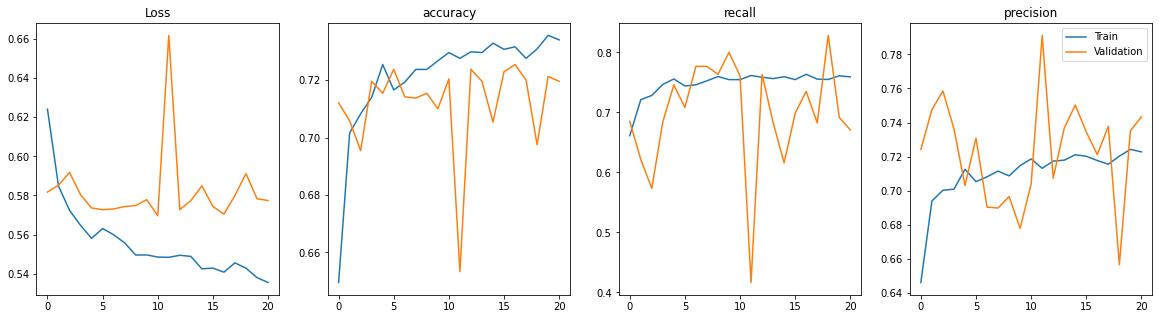

In [31]:
fig,ax = plt.subplots(nrows=1,ncols=4,figsize=(20, 5))
ax[0].plot(fit_data.history['loss'],label="Train")
ax[0].plot(fit_data.history['val_loss'],label="Validation")
ax[0].set_title("Loss")

ax[1].plot(fit_data.history['accuracy'],label="Train")
ax[1].plot(fit_data.history['val_accuracy'],label="Validation")
ax[1].set_title("accuracy")


ax[2].plot(fit_data.history['recall'],label="Train")
ax[2].plot(fit_data.history['val_recall'],label="Validation")
ax[2].set_title("recall")

ax[3].plot(fit_data.history['precision'],label="Train")
ax[3].plot(fit_data.history['val_precision'],label="Validation")
ax[3].set_title("precision")
plt.legend()

plt.show() 

In [32]:
y_train_predict =  nn_model.predict_classes(X_train)
#y_train_predict = [1 if i >= 0.5 else 0 for i in y_train_predict]


y_test_predict = nn_model.predict_classes(X_test)
#y_predict = [1 if i >= 0.5 else 0 for i in y_predict]

y_predict = nn_model.predict_classes(X_validate)


model_name = "NN"
 
metric = {
    "model":model_name,
    "train_score":round(accuracy_score(y_train,y_train_predict),2),
    "test_score":round(accuracy_score(y_test,y_test_predict),2),
    "validate_score":round(accuracy_score(y_validate,y_predict),2),
    "auc":round(roc_auc_score(y_validate,y_predict),2),
    "recall":round(recall_score(y_validate,y_predict),2),
    "precision":round(precision_score(y_validate,y_predict),2),
    "cm":confusion_matrix(y_validate,y_predict)
    }

metrics_data = metrics_data.append(metric,ignore_index = True)
metrics_data[metrics_data["model"] == model_name]

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


,model,train_score,test_score,validate_score,auc,recall,precision,cm
0,NN,0.74,0.72,0.71,0.71,0.64,0.74,"[[231, 69], [107, 193]]"


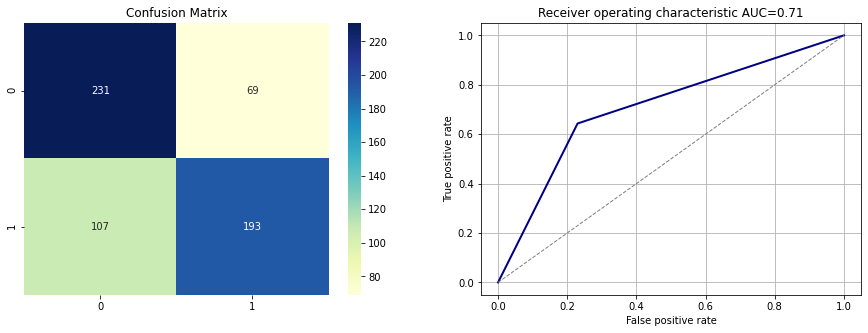

In [33]:
fig,ax = plt.subplots(nrows=1,ncols=2,figsize=(15, 5))
sns.heatmap(confusion_matrix(y_validate,y_predict),annot=True,ax=ax[0],cmap="YlGnBu",fmt="d")
ax[0].set_title('Confusion Matrix'); 
ax[1] = plot_roccurve(y_validate,y_predict)
plt.show() 

#### CNN ( with out transfer learning )

In [35]:
datagen = ImageDataGenerator(
    rotation_range = 50,
    width_shift_range = 0.1,
    height_shift_range = 0.1,
    zoom_range = 0.2,
    horizontal_flip = True
)

datagen.fit(X_train)


def cnn_model():
  model = Sequential()
  model.add(Conv2D(32, (3,3), strides = 1, padding='same', activation='relu', input_shape=(IMG_HEIGHT_WIDTH,IMG_HEIGHT_WIDTH,1)))
  model.add(BatchNormalization())
  model.add(MaxPool2D((2,2), strides=2, padding='same'))
  model.add(Conv2D(64, (3,3), strides=1 ,padding='same', activation='relu'))
  model.add(Dropout(0.1))
  model.add(BatchNormalization())

  model.add(MaxPool2D((2,2), strides=2, padding='same'))
  model.add(Conv2D(64, (3,3), strides=1, padding='same', activation='relu'))
  model.add(BatchNormalization())
  model.add(MaxPool2D((2,2), strides=2, padding='same'))
  model.add(Conv2D(128, (3,3), strides=1, padding='same', activation='relu'))
  model.add(Dropout(0.2))
  model.add(BatchNormalization())

  model.add(MaxPool2D((2,2), strides=2, padding='same'))
  model.add(Conv2D(256, (3,3), strides=1, padding='same', activation='relu'))
  model.add(Dropout(0.2))
  model.add(BatchNormalization())

  model.add(MaxPool2D((2,2), strides=2, padding='same'))
  model.add(Flatten())
  model.add(Dense(units=128, activation='relu'))
  model.add(Dropout(0.2))
  model.add(Dense(units = 1, activation='sigmoid'))
  return model

cnn_model = cnn_model()
optimizer = RMSprop(learning_rate=0.001)

es = EarlyStopping(monitor='val_loss', patience=5,min_delta=0.001)

cnn_model.compile(optimizer = optimizer, loss= tf.keras.losses.BinaryCrossentropy(), 
                   metrics = ["accuracy",
                              tf.keras.metrics.Precision(name="precision"),
                              tf.keras.metrics.Recall(name="recall")])

# learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', 
#                                             patience=3, 
#                                             verbose=1, 
#                                             factor=0.01, 
#                                             min_lr=0.0001)

learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy',patience = 2, verbose=1,factor=0.3, min_lr=0.000001)



fit_data = cnn_model.fit(datagen.flow(X_train, y_train, batch_size=32, shuffle=True),epochs=100, 
    validation_data = (X_test, y_test), callbacks=[es,learning_rate_reduction])

Epoch 1/100
219/219 [==============================] - 41s 82ms/step - loss: 0.7641 - accuracy: 0.6656 - precision: 0.6654 - recall: 0.6660 - val_loss: 0.7875 - val_accuracy: 0.5075 - val_precision: 0.8462 - val_recall: 0.0183
Epoch 2/100
219/219 [==============================] - 10s 45ms/step - loss: 0.5974 - accuracy: 0.7056 - precision: 0.7068 - recall: 0.7026 - val_loss: 0.6624 - val_accuracy: 0.5817 - val_precision: 0.5496 - val_recall: 0.9042
Epoch 3/100
219/219 [==============================] - 10s 46ms/step - loss: 0.5812 - accuracy: 0.7191 - precision: 0.7223 - recall: 0.7120 - val_loss: 0.6511 - val_accuracy: 0.5946 - val_precision: 0.5560 - val_recall: 0.9392
Epoch 4/100
219/219 [==============================] - 18s 80ms/step - loss: 0.5668 - accuracy: 0.7269 - precision: 0.7269 - recall: 0.7269 - val_loss: 0.5738 - val_accuracy: 0.7104 - val_precision: 0.7478 - val_recall: 0.6350
Epoch 5/100
219/219 [==============================] - 18s 80ms/step - loss: 0.5632 - accura

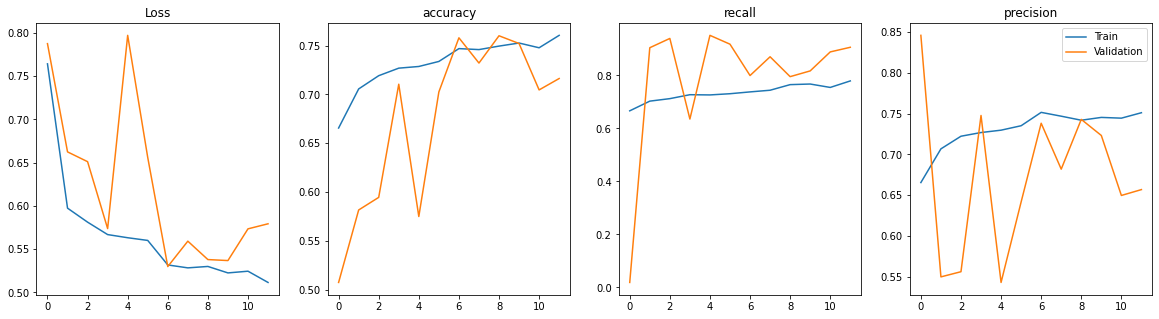

In [36]:
fig,ax = plt.subplots(nrows=1,ncols=4,figsize=(20, 5))
ax[0].plot(fit_data.history['loss'],label="Train")
ax[0].plot(fit_data.history['val_loss'],label="Validation")
ax[0].set_title("Loss")

ax[1].plot(fit_data.history['accuracy'],label="Train")
ax[1].plot(fit_data.history['val_accuracy'],label="Validation")
ax[1].set_title("accuracy")


ax[2].plot(fit_data.history['recall'],label="Train")
ax[2].plot(fit_data.history['val_recall'],label="Validation")
ax[2].set_title("recall")

ax[3].plot(fit_data.history['precision'],label="Train")
ax[3].plot(fit_data.history['val_precision'],label="Validation")
ax[3].set_title("precision")
plt.legend()

plt.show() 

In [37]:
y_train_predict =  cnn_model.predict_classes(X_train)
#y_train_predict = [1 if i >= 0.5 else 0 for i in y_train_predict]


y_test_predict = cnn_model.predict_classes(X_test)
#y_predict = [1 if i >= 0.5 else 0 for i in y_predict]

y_predict = cnn_model.predict_classes(X_validate)


model_name = "CNN"
 
metric = {
    "model":model_name,
    "train_score":round(accuracy_score(y_train,y_train_predict),2),
    "test_score":round(accuracy_score(y_test,y_test_predict),2),
    "validate_score":round(accuracy_score(y_validate,y_predict),2),
    "auc":round(roc_auc_score(y_validate,y_predict),2),
    "recall":round(recall_score(y_validate,y_predict),2),
    "precision":round(precision_score(y_validate,y_predict),2),
    "cm":confusion_matrix(y_validate,y_predict)
    }

metrics_data = metrics_data.append(metric,ignore_index = True)
metrics_data[metrics_data["model"] == model_name]

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


,model,train_score,test_score,validate_score,auc,recall,precision,cm
1,CNN,0.72,0.72,0.72,0.72,0.9,0.66,"[[161, 139], [31, 269]]"


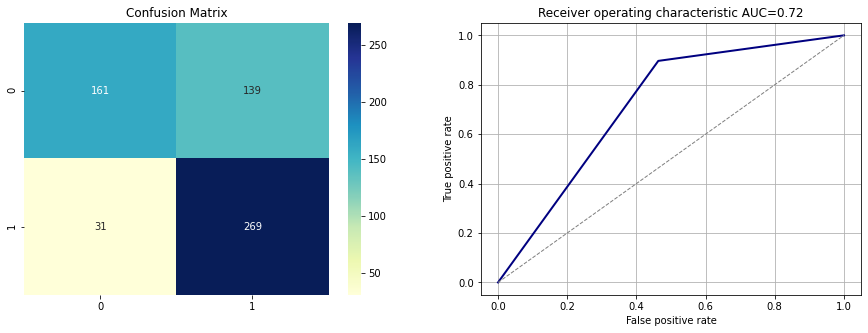

In [40]:
fig,ax = plt.subplots(nrows=1,ncols=2,figsize=(15, 5))
sns.heatmap(confusion_matrix(y_validate,y_predict),annot=True,ax=ax[0],cmap="YlGnBu",fmt="d")
ax[0].set_title('Confusion Matrix'); 
ax[1] = plot_roccurve(y_validate,y_predict)
plt.show() 

In [41]:
metrics_data

,model,train_score,test_score,validate_score,auc,recall,precision,cm
0,NN,0.74,0.72,0.71,0.71,0.64,0.74,"[[231, 69], [107, 193]]"
1,CNN,0.72,0.72,0.72,0.72,0.90,0.66,"[[161, 139], [31, 269]]"
